# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [15]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4.1-mini"
# openai = OpenAI()
openrouter_api_key = os.getenv('OPENROUTER_API_KEY')
openrouter_base_url = os.getenv('OPENROUTER_BASE_URL')
openai = OpenAI(api_key=openrouter_api_key, base_url=openrouter_base_url)

DB = "prices.db"

OpenAI API Key exists and begins sk-proj-


In [18]:
response = openai.chat.completions.create(model='openai/gpt-4o-mini', messages=[{"role": "user", "content": "Hello, world!"}])
response.choices[0].message.content

'Hello! How can I assist you today?'

In [3]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [4]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [5]:
get_ticket_price("Paris")

DATABASE TOOL CALLED: Getting price for Paris


'Ticket price to Paris is $899.0'

In [6]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [19]:

def chat(message, history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


In [20]:
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [21]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Paris


## A bit more about what Gradio actually does:

1. Gradio constructs a frontend Svelte app based on our Python description of the UI
2. Gradio starts a server built upon the Starlette web framework listening on a free port that serves this React app
3. Gradio creates backend routes for our callbacks, like chat(), which calls our functions

And of course when Gradio generates the frontend app, it ensures that the the Submit button calls the right backend route.

That's it!

It's simple, and it has a result that feels magical.

# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [23]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [ ]:
# def artist(city):
#     image_response = openai.images.generate(
#             # model="dall-e-3",
#             model = "openai/gpt-5-image-mini",
#             prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
#             size="1024x1024",
#             n=1,
#             response_format="b64_json",
#         )
#     image_base64 = image_response.data[0].b64_json
#     image_data = base64.b64decode(image_base64)
#     return Image.open(BytesIO(image_data))

In [ ]:
import requests
import json

def artist(city): 
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {openrouter_api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "openai/gpt-5-image-mini",
        "messages": [
            {
                "role": "user",
                "content": f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style"
            }
        ],
        "modalities": ["image", "text"],
        "image_config": {
            # "aspect_ratio": "16:9"
            "size": "1024x1024"
        }
    }

    response = requests.post(url, headers=headers, json=payload)
    result = response.json()

    if result.get("choices"):
        message = result["choices"][0]["message"]
        if message.get("images"):
            for image in message["images"]:
                image_url = image["image_url"]["url"]
                print(f"Generated image: {image_url[:50]}...")
    
    # Strip prefix if present
    if image_url.startswith("data:image"):
        image_url = image_url.split(",")[1]

    # Decode and open with PIL
    image = Image.open(BytesIO(base64.b64decode(image_url)))
      
    return image

In [58]:
image = artist("New York City")

Generated image: data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABAAA...


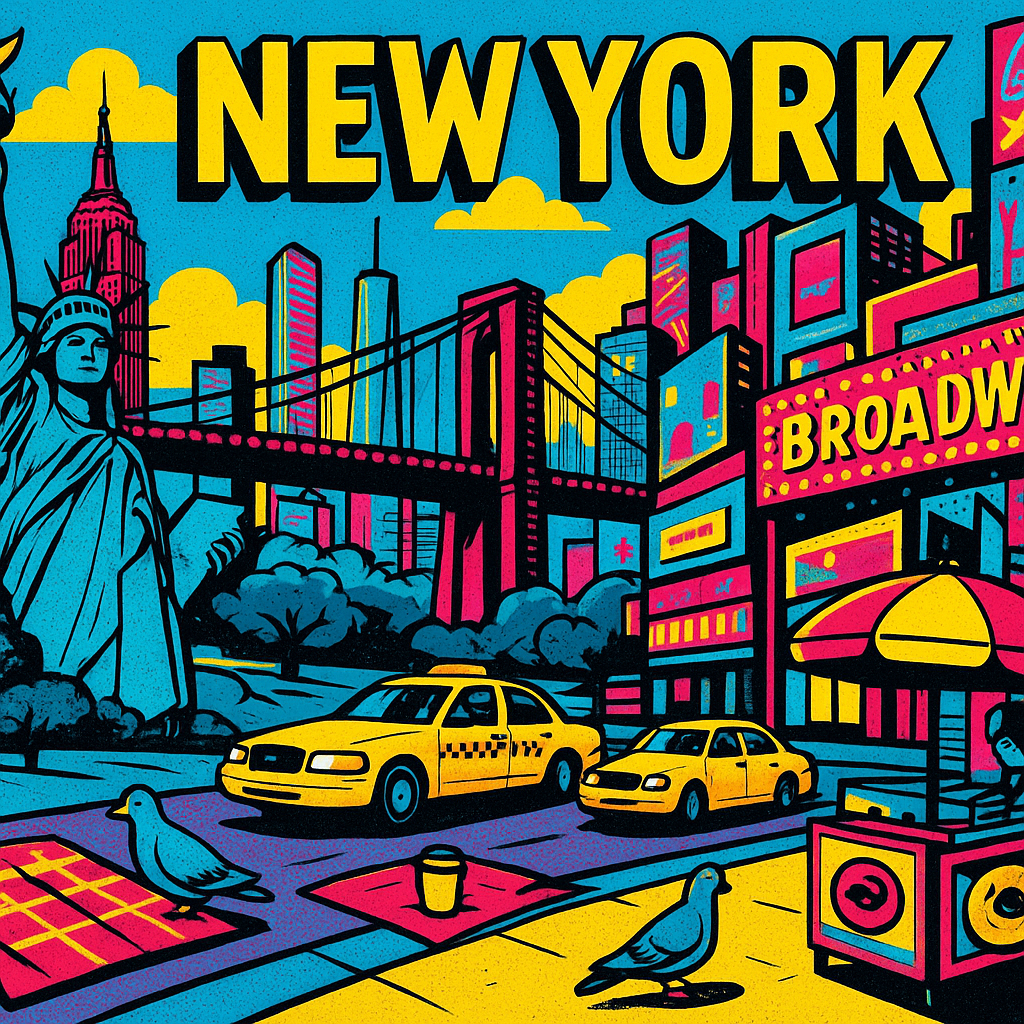

In [66]:
img = Image.open(BytesIO(base64.b64decode(image)))
img

In [ ]:
def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

## Let's bring this home:

1. A multi-modal AI assistant with image and audio generation
2. Tool callling with database lookup
3. A step towards an Agentic workflow


In [ ]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = artist(cities[0])
    
    return history, voice, image


In [ ]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

## The 3 types of Gradio UI

`gr.Interface` is for standard, simple UIs

`gr.ChatInterface` is for standard ChatBot UIs

`gr.Blocks` is for custom UIs where you control the components and the callbacks

In [83]:
system_message = """You are a helpful AI editor. Use a natural and friendly tone that doesn't sound like a robot. Avoid bullet points and lists."""

prompt = """
Edit the following email. Previous correspondence is below the ### 
Draft:
Hi LeongYan, Vincent, Jeremy,
I’m pleased to introduce the new Berkeley Club of Singapore exco:
Chris Fong and Erica Ding, our incoming Co-Presidents, and Audrey McGrath who'll be coordinating mentorship initiatives with various schools in Singapore. 
As we've discussed, they're eager to collaborate on range of activities including mentorship opportunities for current students, as well as social and professional networking events

Hi Chris, Erica, and Audrey, 
Introducing LeongYan, co-founder of the Raffles Business Network (RBN), Jeremy Sing, who organized a major event for RBN recently, and Vincent Ng, also President of the USC Alunmni Club
They'd like to meet up for coffee to connect first

Best regards,
Mark

###
Previous correspondence:

Mark Yong <mark.yong.sg@gmail.com>
Tue, Nov 4, 10:10 PM (7 days ago)
to LeongYan, Vincent, Jeremy, Roger, Kevin

Hi LeongYan,

Thanks for the introduction and for sharing about upcoming RBN activities; I enjoyed myself greatly at the previous Rafflesian watering hole event. 

Hi Vincent, Jeremy,

Great e-meeting the 2 of you! For the coffee meet-up, let’s plan to catch up once the new Cal alumni exco is confirmed; I’ll bring them into the conversation after this week.

Wishing everyone a great close to the year, and I look forward to meeting in person soon. If you need to reach me outside of email, my mobile number's 90022009.

Mark

On Sat, Nov 1, 2025 at 6:54 AM LeongYan Yoong <yoongleongyan@gmail.com> wrote:
  
 Dear Mark, thanks for reaching out and really appreciate it. 
 And indeed,  we are also getting organized on our side at RBN after a strong event
 we had at our Rafflesian watering hole (social) at Winery at Chijmes (which is owned
 by Calvin Lim). This event was led by Jeremy Sing. 

Would like to introduce to you Vincent Ng who is also the President of the USC Alumni
 Club in Singapore. Vincent organises the football viewings at the Sail ( SC plays Nebraska
 tmrw at 730am ). Would love for Vincent, Jeremy and you to meet over coffee if available 
 to connect first. Our next business networking event at RBN is on Nov20th at Chupitos
 ( featuring Rafflesian Business Owners #RBOs ) and also on Jan29th at Prudential 
 featuring the Future of Healthcare topic ( hosted by Prudential CEO San San ). You have
 been invited on Luma for both. 

Thanks for your kind support of RBN and hope to meet you soon too. Any questions
 do let us know and really appreciate you reaching out. Have a great Q4 festive period
 ahead! 

LeongYan, m96252175 ( Rafflesian/Trojan alumni )
  
From: Mark Yong <mark.yong.sg@gmail.com>
Sent: Thursday, October 30, 2025 1:39 PM
To: rbn@rafflesian.com <rbn@rafflesian.com>
Subject: Collaboration between Rafflesian Business Network & Berkeley Club of Singapore
 
Hi there,

I hope you’ve been doing well. I’m Mark Yong Enhan, RI Class of ’99.

I wanted to reach out as the expected incoming Exco of the Berkeley Club of Singapore has expressed interest in connecting with ORA, RBN, and current RI students. There’s quite a bit of overlap among the communities, and it seems like a natural opportunity to collaborate.

Some potential areas of collaboration include social and professional networking events, as well as mentorship opportunities for current students.

I hope I’m not too forward in reaching out ahead of formal confirmation, the Exco composition should be finalized shortly, and they are aiming to meet formally after the first week of November.

Warm regards,
Mark Yong
RI Class of ’99
"""



In [84]:
response = openai.chat.completions.create(model='openrouter/polaris-alpha', messages=[{"role": "system", "content": system_message}, {"role": "user", "content": prompt}])
result = response.choices[0].message.content
result

'Hi LeongYan, Vincent, Jeremy,  \n\nI’m pleased to introduce the new Berkeley Club of Singapore Exco: Chris Fong and Erica Ding, our incoming Co-Presidents, and Audrey McGrath, who will be coordinating mentorship initiatives with various schools in Singapore. As discussed, they are keen to explore collaborations across mentorship for students, as well as social and professional networking events with your communities.  \n\nHi Chris, Erica and Audrey,  \n\nI’d also like to introduce LeongYan, co-founder of the Raffles Business Network (RBN), Jeremy Sing, who led a major recent RBN event, and Vincent Ng, who is also President of the USC Alumni Club in Singapore. They are keen to meet over coffee to connect and discuss potential collaboration opportunities.  \n\nBest regards,  \nMark'

In [85]:
print(result)

Hi LeongYan, Vincent, Jeremy,  

I’m pleased to introduce the new Berkeley Club of Singapore Exco: Chris Fong and Erica Ding, our incoming Co-Presidents, and Audrey McGrath, who will be coordinating mentorship initiatives with various schools in Singapore. As discussed, they are keen to explore collaborations across mentorship for students, as well as social and professional networking events with your communities.  

Hi Chris, Erica and Audrey,  

I’d also like to introduce LeongYan, co-founder of the Raffles Business Network (RBN), Jeremy Sing, who led a major recent RBN event, and Vincent Ng, who is also President of the USC Alumni Club in Singapore. They are keen to meet over coffee to connect and discuss potential collaboration opportunities.  

Best regards,  
Mark


In [ ]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("ed", "bananas"))

# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>